# Introduction

In this assignment you will practice putting together a simple image classification pipeline with both non-parametric and parametric methods.

In paticular, we will work with the k-Nearest Neighbor, the SVM classifier and the 2-Layered Neural Network for [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. The goals of this assignment are as follows:



*   Understand the basic Image Classification pipeline and the data-driven approach (train/predict stages).
*   Understand the train/val/test splits and the use of validation data for hyperparameter tuning.
*   Implement and apply a Weighted k-Nearest Neighbor (kNN) classifier.
*   Implement and apply a Multiclass Support Vector Machine (SVM) classifier.
*   Implement and apply a 2-layered Neural Network.
*   Understand the differences and tradeoffs between these classifiers.

Please fill in all the **TODO** code blocks. Once you are ready to submit:

* Export the notebook `CSCI677_spring25_assignment_2.ipynb` as a PDF `[Your USC ID]_CSCI677_spring25_assignment_2.pdf`
* Submit your PDF file through Brightspace.

Please make sure that the notebook have been run before exporting PDF, and your code and all cell outputs are visible in the your submitted PDF. Regrading request will not be accepted if your code/output is not visible in the original submission. Thank you!

# **Data Preparation**

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) is a well known dataset composed of 60,000 colored 32x32 images. The utility function `cifar10()` returns the entire CIFAR-10 dataset as a set of four Torch tensors:
* `x_train` contains all training images (real numbers in the range  [0,1] )
* `y_train` contains all training labels (integers in the range  [0,9] )
* `x_test` contains all test images
* `y_test` contains all test labels

This function automatically downloads the CIFAR-10 dataset the first time you run it.

In [1]:
import os
import time
import torch
import numpy as np
from torchvision.datasets import CIFAR10
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F

In [2]:
def _extract_tensors(dset, num=None):
    x = torch.tensor(dset.data, dtype=torch.float32).permute(0, 3, 1, 2).div_(255)
    y = torch.tensor(dset.targets, dtype=torch.int64)
    if num is not None:
        if num <= 0 or num > x.shape[0]:
          raise ValueError('Invalid value num=%d; must be in the range [0, %d]'
                          % (num, x.shape[0]))
        x = x[:num].clone()
        y = y[:num].clone()
    return x, y

def cifar10(num_train=None, num_test=None):
    download = not os.path.isdir('cifar-10-batches-py')
    dset_train = CIFAR10(root='.', download=download, train=True)
    dset_test = CIFAR10(root='.', train=False)
    x_train, y_train = _extract_tensors(dset_train, num_train)
    x_test, y_test = _extract_tensors(dset_test, num_test)

    return x_train, y_train, x_test, y_test

Our data is going to be stored simply in the four variables: `x_train`, `x_test`, `y_train`, and `y_test`.


*   Training set: `x_train` is composed of 50,000 images where `y_train` references the corresponding labels.
*   Testing set: `x_test` is composed of 10,000 images where `y_test` references the corresponding labels.

In [3]:
torch.manual_seed(0)
num_train = 50000
num_test = 5000
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

x_train, y_train, x_test, y_test = cifar10(num_train, num_test)

# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

x_train_np = x_train.numpy()
y_train_np = y_train.numpy()
x_test_np = x_test.numpy()
y_test_np = y_test.numpy()

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = x_train_np[mask]
y_val = y_train_np[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = x_train_np[mask]
y_train = y_train_np[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = x_train_np[mask]
y_dev = y_train_np[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = x_test_np[mask]
y_test = y_test_np[mask]

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

X_train, X_test, X_dev, X_val = torch.FloatTensor(X_train), torch.FloatTensor(X_test), torch.FloatTensor(X_dev), torch.FloatTensor(X_val)
y_train, y_test, y_dev, y_val = torch.LongTensor(y_train), torch.LongTensor(y_test), torch.LongTensor(y_dev), torch.LongTensor(y_val)
print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)
torch.Size([49000, 3073]) torch.Size([1000, 3073]) torch.Size([1000, 3073]) torch.Size([500, 3073])


# k-Nearest Neighbor (kNN) (20 pts)


## **Subsampling**

When implementing machine learning algorithms, it's usually a good idea to use a small sample of the full dataset. This way your code will run much faster, allowing for more interactive and efficient development. Once you are satisfied that you have correctly implemented the algorithm, you can then rerun with the entire dataset.

In [4]:
# Subsample size
def subsample(X, y, n):
    assert len(X) == len(y)
    indices = torch.randint(len(X), (n,))
    return X[indices],  y[indices]
ss_x_train, ss_y_train = subsample(X_train, y_train, 500)
print(ss_x_train.shape, ss_y_train.shape)

torch.Size([500, 3073]) torch.Size([500])


## Compute Distance (5 pts)

Now that we have examined and prepared our data, it is time to implement the Weighted-kNN classifier. We can break the process down into two steps:
1. Compute the consine similarities between all training examples and all test examples
2. Given these pre-computed similarities, for each test example find its k nearest neighbors and have them vote for the label to output

**NOTE**: When implementing algorithms in PyTorch, it's best to avoid loops in Python if possible. Instead it is preferable to implement your computation so that all loops happen inside PyTorch functions. This will usually be much faster than writing your own loops in Python, since PyTorch functions can be internally optimized to iterate efficiently, possibly using multiple threads. This is especially important when using a GPU to accelerate your code.

In [5]:
def compute_distances(x_train, x_test):
    """
    Inputs:
    x_train: shape (num_train, C, H, W) tensor.
    x_test: shape (num_test, C, H, W) tensor.

    Returns:
    dists: shape (num_train, num_test) tensor where dists[j, i] is the
        cosine similarity between the ith training image and the jth test
        image.
    """

    # Get the number of training and testing images
    num_train = x_train.shape[0]
    num_test = x_test.shape[0]

    # dists will be the tensor housing all distance measurements between testing and training
    dists = x_train.new_zeros(num_train, num_test)

    # Flatten tensors
    train = x_train.flatten(1)
    test = x_test.flatten(1)

    #######################################################################
    # TODO (5 pts):
    # find the consine similarities between testing and training images,
    # and save the computed distance in dists.
    #######################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)****
    for i in range(num_train):
        dists[i] = F.cosine_similarity(train[i], test)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return dists

In [ ]:
ss_x_test, ss_y_test = subsample(X_test, y_test, 500)
print(compute_distances(ss_x_train, ss_x_test).shape)

## Implement Weighted-kNN (10 pts)

The Weighted-kNN classifier consists of two stages:

*   Training: the classifier takes the training data and simply remembers it
*   Testing: For each test sample, the classifier computes the similarity to all training samples and selects the k most similar neighbors. Instead of simple majority voting, each neighbor contributes to the final prediction based on its similarity with the test sample. This ensures that more similar neighbors have a greater influence on the classification decision.

In [ ]:
from collections import defaultdict

class KnnClassifier:
    def __init__(self, x_train, y_train):
        """
        x_train: shape (num_train, C, H, W) tensor where num_train is batch size,
          C is channel size, H is height, and W is width.
        y_train: shape (num_train) tensor where num_train is batch size providing labels
        """

        self.x_train = x_train
        self.y_train = y_train

    def predict(self, x_test, k=1):
        """
        x_test: shape (num_test, C, H, W) tensor where num_test is batch size,
          C is channel size, H is height, and W is width.
        k: The number of neighbors to use for prediction
        """

        # Init output shape
        y_test_pred = torch.zeros(x_test.shape[0], dtype=torch.int64)

        # Find & store Euclidean distance between test & train
        dists = compute_distances(self.x_train, x_test)

        #######################################################################
        # TODO (10 pts):
        # The goal is to return a tensor y_test_pred where the ith index
        # is the assigned label to ith test image by the kNN algorithm.
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # 1. Index over test images

        # 2. Find the indices of the k most similar training samples (highest cosine similarity).

        # 3. Retrieve the labels of these k neighbors and compute their contributions as the similarity scores

        # 4. Assign the label with the highest accumulated weight as the final prediction.
        #######################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        for i in range(x_test.size(0)):
            scores = defaultdict(int)
            sorted = dists[:, i].sort(descending=True)
            topk_inds, topk_vals = sorted.indices[:k], sorted.values[:k]
            for ind, weight in zip(topk_inds, topk_vals):
                label = self.y_train[ind].item()
                scores[label] += weight
            pred_label = max(scores, key=scores.get)
            y_test_pred[i] = pred_label
        
        return y_test_pred

    def check_accuracy(self, x_test, y_test, k=1, quiet=False):
        """
        x_test: shape (num_test, C, H, W) tensor where num_test is batch size,
          C is channel size, H is height, and W is width.
        y_test: shape (num_test) tensor where num_test is batch size providing labels
        k: The number of neighbors to use for prediction
        quiet: If True, don't print a message.

        Returns:
        accuracy: Accuracy of this classifier on the test data, as a percent.
          Python float in the range [0, 100]
        """

        y_test_pred = self.predict(x_test, k=k)
        num_samples = x_test.shape[0]
        num_correct = (y_test == y_test_pred).sum().item()
        accuracy = 100.0 * num_correct / num_samples
        msg = (f'Got {num_correct} / {num_samples} correct; '
              f'accuracy is {accuracy:.2f}%')
        if not quiet:
          print(msg)
        return accuracy

We've finished implementing kNN and can begin testing the algorithm on larger portions of the dataset to see how well it performs.

In [ ]:
torch.manual_seed(0)
num_train = 5000
num_test = 500
num_val = 500
knn_x_train, knn_y_train = subsample(X_train, y_train, num_train)
knn_x_test, knn_y_test = subsample(X_test, y_test, num_test)
knn_x_val, knn_y_val = subsample(X_val, y_val, num_val)
classifier = KnnClassifier(knn_x_train, knn_y_train)
classifier.check_accuracy(knn_x_test, knn_y_test, k=5)

## Hyperparameter Tuning (5 pts)

Now we use the validation set to tune hyperparameters (number of nearest neighbors k). You should experiment with different ranges of k.

In [ ]:
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_k = None # The value of k that achieved the highest validation rate.

################################################################################
# TODO (5 pts):                                                               #
# Write code that chooses the best k value by tuning on the validation         #
# set. For each value of k, train a KnnClassifier on the                       #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the best value of k in best_k.           #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# fill in your own values
k_choices = [7, 9, 10]
for k in k_choices:
    acc = classifier.check_accuracy(knn_x_val, knn_y_val, k=k)
    results[k] = acc
    if best_val < acc:
        best_val = acc
        best_k = k

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for k in sorted(results):
    val_accuracy = results[k]
    print('k %d val accuracy: %f' % (
                k, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

classifier = KnnClassifier(knn_x_train, knn_y_train)
test_acc = classifier.check_accuracy(knn_x_test, knn_y_test, k=best_k)
print('final test accuracy knn achieved: %f' % test_acc)

# Define a General Classifier Class (15 pts)

Before implementing Support Vector Machine (SVM) Classifier. We define a general classifier class that contains the following main functions:


1.   `train`: train this linear classifier using stochastic gradient descent.
2.   `predict`: use the trained weights of this linear classifier to predict labels for data points.
3.   `loss`: compute the loss function and its derivative.

We will define SVM and Softmax classifier as subclasses of this general linear classifier class. Subclasses will override the `loss` function.





In [ ]:
class LinearClassifier(object):
    def __init__(self):
        self.W = None

    def train(
        self,
        X,
        y,
        learning_rate=1e-3,
        reg=1e-5,
        num_iters=100,
        batch_size=200,
        verbose=False,
    ):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = (
            np.max(y) + 1
        )  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO (5 pts):                                                        #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            X_inds, y_inds = np.random.choice(X.shape[0], size=batch_size, replace=False), np.random.choice(y.shape[0], size=batch_size, replace=False)
            X_batch, y_batch = X[X_inds], y[X_inds]

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO (5 pts):                                                         #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            self.W -= learning_rate * grad
            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print("iteration %d / %d: loss %f" % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO (5 pts):                                                           #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        y_pred = X @ self.W 
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return np.argmax(y_pred, axis=1)

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """

# Multiclass Support Vector Machine (SVM) (25 pts)



[Support vector machines (SVMs)](https://scikit-learn.org/stable/modules/svm.html) are a set of supervised learning methods used for classification.

The advantages of support vector machines are:

* Effective in high dimensional spaces.
* Still effective in cases where number of dimensions is greater than the number of samples.
* Uses a subset of training points in the decision function (called support vectors), so it is also memory efficient.
* Versatile: different Kernel functions can be specified for the decision function. Common kernels are provided, but it is also possible to specify custom kernels.

The disadvantages of support vector machines include:

* If the number of features is much greater than the number of samples, avoid over-fitting in choosing Kernel functions and regularization term is crucial.
* SVMs do not directly provide probability estimates, these are calculated using an expensive five-fold cross-validation (see Scores and probabilities, below).

In this section, we will first implement the loss function for SVM and use the validation set to tune hyperparameters.

**NOTE:** please use [numpy](https://numpy.org/), please do not use [scikit-learn](https://scikit-learn.org/stable/), [PyTorch](https://pytorch.org/) or other libraries.

## Loss Function (20 pts)

We first structure the loss function for SVM. For detailed explanations of SVM loss, please check out [this reading material](https://cs231n.github.io/linear-classify/#loss-function).

In [ ]:
def svm_loss(W, X, y, reg):
    """
    Structured SVM loss function implementation.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    loss = 0.0
    dW = np.zeros(W.shape)  # initialize the gradient as zero

    #############################################################################
    # TODO (10 pts):                                                            #
    # Implement a vectorized version of the structured SVM loss, storing the    #
    # result in loss. Refer to https://cs231n.github.io/linear-classify/        #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    delta = 0.0
    scores = X @ W  # N x C
    correct_scores = scores[np.arange(scores.shape[0]), y]
    margins = np.maximum(0.0, scores - correct_scores.reshape(-1, 1).repeat(10, -1) + delta)  # N x C
    margins[np.arange(scores.shape[0]), y] = delta
    margin_loss = np.sum(margins) / scores.shape[0]
    reg_loss = np.sum(np.linalg.norm(W, 2)) * reg
    loss = margin_loss + reg_loss

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    #############################################################################
    # TODO (10 pts):                                                            #
    # Implement a vectorized version of the gradient for the structured SVM     #
    # loss, storing the result in dW.                                           #
    #                                                                           #
    # Hint: Instead of computing the gradient from scratch, it may be easier    #
    # to reuse some of the intermediate values that you used to compute the     #
    # loss.                                                                     #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    margin_mask = (scores - correct_scores.reshape(-1, 1) + delta > 0).astype(np.float32)  # N x C, X is N x D,   (C x N) x (N x D)
    dW = margin_mask.T @ X # C x D
    # gradient from l2 regularization
    dW += 2 * W.T * reg
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW.T


Now, we can test our implementation of SVM loss.

In [ ]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

tic = time.time()
loss, _ = svm_loss(W, X_dev.numpy(), y_dev.numpy(), 0.000005)
toc = time.time()
print('loss: %e computed in %fs' % (loss, toc - tic))

In [ ]:
class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss(self.W, X_batch, y_batch, reg)

In [ ]:
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train.numpy(), y_train.numpy(), learning_rate=1e-7, reg=2.5e-4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))


In [ ]:
y_train_pred = svm.predict(X_train.numpy())
print('training accuracy: %f' % (np.mean(y_train.numpy() == y_train_pred), ))
y_val_pred = svm.predict(X_val.numpy())
print('validation accuracy: %f' % (np.mean(y_val.numpy() == y_val_pred), ))

## Hyperparameter Tuning (5 pts)

Now we use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths.

**Note:** you may see runtime/overflow warnings during hyper-parameter search. This may be caused by extreme values, and is not a bug.

In [ ]:

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO (10 pts):                                                               #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# Fill in your own values
learning_rates = [1e-4, 1e-7, 1e-9]
regularization_strengths = [1e-3, 1e-5, 1e-7]

for lr in learning_rates:
    for reg in regularization_strengths:
        print(f"Running model with {lr=}, {reg=}")
        model = LinearSVM()
        model.train(X_train.numpy(), y_train.numpy(), learning_rate=lr, reg=reg,
                      num_iters=1500, verbose=False)

        y_train_pred = svm.predict(X_train.numpy())
        train_acc = np.mean(y_train.numpy() == y_train_pred)
        y_val_pred = svm.predict(X_val.numpy())
        val_acc = np.mean(y_val.numpy() == y_val_pred)
        results[(lr, reg)] = (train_acc, val_acc)

        if val_acc > best_val:
            best_val = val_acc
            best_svm = model

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)
y_test_pred = best_svm.predict(X_test.numpy())
test_acc = np.mean(y_test.numpy() == y_test_pred)
print('final test accuracy svm achieved: %f' % test_acc)

# Implementing a Neural Network (40 pts)
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

We train the network with a cross-entropy loss function and L2 regularization on the weight matrices. The network uses a Sigmoid nonlinearity after the first fully connected layer. 

In other words, the network has the following architecture:

  input -> fully connected layer -> Sigmoid -> fully connected layer -> softmax -> cross-entropy

The outputs of the second fully-connected layer are the scores for each class.

**Note**: When you implement the regularization over W, **please DO NOT multiply the regularization term by 1/2** (no coefficient). 






In [6]:
# Template class modules that we will use later: Do not edit/modify this class
class TwoLayerNet(object):
  def __init__(self, input_size, hidden_size, output_size,
               dtype=torch.float32, device='cuda', std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    - dtype: Optional, data type of each initial weight params
    - device: Optional, whether the weight params is on GPU or CPU
    - std: Optional, initial weight scaler.
    """
    # reset seed before start
    random.seed(0)
    torch.manual_seed(0)

    self.params = {}
    self.params['W1'] = std * torch.randn(input_size, hidden_size, dtype=dtype, device=device)
    self.params['b1'] = torch.zeros(hidden_size, dtype=dtype, device=device)
    self.params['W2'] = std * torch.randn(hidden_size, output_size, dtype=dtype, device=device)
    self.params['b2'] = torch.zeros(output_size, dtype=dtype, device=device)

  def loss(self, X, y=None, reg=0.0):
    return nn_forward_backward(self.params, X, y, reg)

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
    return nn_train(
            self.params,
            nn_forward_backward,
            nn_predict,
            X, y, X_val, y_val,
            learning_rate, learning_rate_decay,
            reg, num_iters, batch_size, verbose)

  def predict(self, X):
    return nn_predict(self.params, nn_forward_backward, X)

  def save(self, path):
    torch.save(self.params, path)
    print("Saved in {}".format(path))

  def load(self, path):
    checkpoint = torch.load(path, map_location='cpu')
    self.params = checkpoint
    print("load checkpoint file: {}".format(path))


Forward pass function (5 pts)

In [7]:
def nn_forward_pass(params, X):
    """
    The first stage of our neural network implementation: Run the forward pass
    of the network to compute the hidden layer features and classification
    scores. The network architecture should be:

    FC layer -> ReLU (hidden) -> FC layer (scores)

    As a practice, we will NOT allow to use torch.relu and torch.nn ops
    just for this time (you can use it from A3).

    Inputs:
    - params: a dictionary of PyTorch Tensor that store the weights of a model.
      It should have following keys with shape
          W1: First layer weights; has shape (D, H)
          b1: First layer biases; has shape (H,)
          W2: Second layer weights; has shape (H, C)
          b2: Second layer biases; has shape (C,)
    - X: Input data of shape (N, D). Each X[i] is a training sample.

    Returns a tuple of:
    - scores: Tensor of shape (N, C) giving the classification scores for X
    - hidden: Tensor of shape (N, H) giving the hidden layer representation
      for each input value (after the ReLU).
    """
    # Unpack variables from the params dictionary
    W1, b1 = params['W1'], params['b1']
    W2, b2 = params['W2'], params['b2']
    N, D = X.shape

    # Compute the forward pass
    hidden = None
    scores = None
    def activation(z):
      return 1 / (1 + torch.exp(-z))
    ############################################################################
    # TODO: Perform the forward pass, computing the class scores for the input.#
    # Store the result in the scores variable, which should be an tensor of    #
    # shape (N, C).                                                            #
    ############################################################################
    # Replace "pass" statement with your code
    hidden = activation(X @ W1 + b1)
    scores = hidden @ W2 + b2
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return scores, hidden

Loss function + Gradients computation (15 pts)

In [8]:
def nn_forward_backward(params, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network. When you implement loss and gradient, please don't forget to
    scale the losses/gradients by the batch size.

    Inputs: First two parameters (params, X) are same as nn_forward_pass
    - params: a dictionary of PyTorch Tensor that store the weights of a model.
      It should have following keys with shape
          W1: First layer weights; has shape (D, H)
          b1: First layer biases; has shape (H,)
          W2: Second layer weights; has shape (H, C)
          b2: Second layer biases; has shape (C,)
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, return a tensor scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = params['W1'], params['b1']
    W2, b2 = params['W2'], params['b2']
    N, D = X.shape
    C = params['W2'].shape[1]

    scores, hidden = nn_forward_pass(params, X)
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores

    # Compute the loss
    loss = None
    ############################################################################
    # TODO: Compute the loss, based on the results from nn_forward_pass.       #
    # This should include both the data loss and L2 regularization for W1 and  #
    # W2. Store the result in the variable loss, which should be a scalar. Use #
    # the Cross-entropy classifier loss.                                       #
    # Please DO NOT multiply the regularization term by 1/2 (no coefficient).  #
    # If you are not careful here, it is easy to run into numeric instability  #
    # (Check Numeric Stability in http://cs231n.github.io/linear-classify/).   #
    ############################################################################
    # Replace "pass" statement with your code
    # scores is N x C
    def softmax(x):
        # use numerical stability trick
        exp_scores = torch.exp(x - torch.max(x, dim=1, keepdim=True).values)
        probs = exp_scores / exp_scores.sum(dim=1, keepdim=True)
        return probs


    probs = softmax(scores) # N x C
    correct_probs = probs[torch.arange(N), y]
    ce_loss = -torch.log(correct_probs).mean()
    reg_loss = (W1.pow(2).sum() + W2.pow(2).sum()) * reg
    loss = ce_loss + reg_loss
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    # Backward pass: compute gradients
    grads = {}
    ###########################################################################
    # TODO: Compute the backward pass, computing the derivatives of the       #
    # weights and biases. Store the results in the grads dictionary.          #
    # For example, grads['W1'] should store the gradient on W1, and be a      #
    # tensor of same size                                                     #
    ###########################################################################
    # Replace "pass" statement with your code
    # gradient of loss wrt output y
    dscores = probs.clone()
    dscores[torch.arange(N), y] -= 1
    dscores /= N

    grads['W2'] = hidden.T @ dscores
    grads['b2'] = dscores.sum(dim=0)

    # d/dH ( W2 x H + b) = W2 * H'
    dhidden = dscores @ W2.T
    dhidden *= hidden * (1 - hidden)

    # grads for W1 and b1
    grads['W1'] = X.T @ dhidden
    grads['b1'] = dhidden.sum(dim=0)

    # gradient from regularization loss
    grads['W2'] += 2 * reg * W2
    grads['W1'] += 2 * reg * W1

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

    return loss, grads

Weight updates (5 pts)

In [9]:
def nn_train(params, loss_func, pred_func, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
  """
  Train this neural network using stochastic gradient descent.

  Inputs:
  - params: a dictionary of PyTorch Tensor that store the weights of a model.
    It should have following keys with shape
        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)
  - loss_func: a loss function that computes the loss and the gradients.
    It takes as input:
    - params: Same as input to nn_train
    - X_batch: A minibatch of inputs of shape (B, D)
    - y_batch: Ground-truth labels for X_batch
    - reg: Same as input to nn_train
    And it returns a tuple of:
      - loss: Scalar giving the loss on the minibatch
      - grads: Dictionary mapping parameter names to gradients of the loss with
        respect to the corresponding parameter.
  - pred_func: prediction function that im
  - X: A PyTorch tensor of shape (N, D) giving training data.
  - y: A PyTorch tensor f shape (N,) giving training labels; y[i] = c means that
    X[i] has label c, where 0 <= c < C.
  - X_val: A PyTorch tensor of shape (N_val, D) giving validation data.
  - y_val: A PyTorch tensor of shape (N_val,) giving validation labels.
  - learning_rate: Scalar giving learning rate for optimization.
  - learning_rate_decay: Scalar giving factor used to decay the learning rate
    after each epoch.
  - reg: Scalar giving regularization strength.
  - num_iters: Number of steps to take when optimizing.
  - batch_size: Number of training examples to use per step.
  - verbose: boolean; if true print progress during optimization.

  Returns: A dictionary giving statistics about the training process
  """
  num_train = X.shape[0]
  iterations_per_epoch = max(num_train // batch_size, 1)

  # Use SGD to optimize the parameters in self.model
  loss_history = []
  train_acc_history = []
  val_acc_history = []

  for it in range(num_iters):
    indices = torch.randint(num_train, (batch_size,))
    y_batch = y[indices]
    X_batch = X[indices]

    # Compute loss and gradients using the current minibatch
    loss, grads = loss_func(params, X_batch, y=y_batch, reg=reg)
    loss_history.append(loss.item())

    #########################################################################
    # TODO: Use the gradients in the grads dictionary to update the         #
    # parameters of the network (stored in the dictionary self.params)      #
    # using stochastic gradient descent. You'll need to use the gradients   #
    # stored in the grads dictionary defined above.                         #
    #########################################################################
    # Replace "pass" statement with your code
    params['W1'] -= learning_rate * grads['W1']
    params['b1'] -= learning_rate * grads['b1']
    params['W2'] -= learning_rate * grads['W2']
    params['b2'] -= learning_rate * grads['b2']
    #########################################################################
    #                             END OF YOUR CODE                          #
    #########################################################################

    if verbose and it % 100 == 0:
      print('iteration %d / %d: loss %f' % (it, num_iters, loss.item()))

    # Every epoch, check train and val accuracy and decay learning rate.
    if it % iterations_per_epoch == 0:
      # Check accuracy
      y_train_pred = pred_func(params, loss_func, X_batch)
      train_acc = (y_train_pred == y_batch).float().mean().item()
      y_val_pred = pred_func(params, loss_func, X_val)
      val_acc = (y_val_pred == y_val).float().mean().item()
      train_acc_history.append(train_acc)
      val_acc_history.append(val_acc)

      # Decay learning rate
      learning_rate *= learning_rate_decay

  return {
    'loss_history': loss_history,
    'train_acc_history': train_acc_history,
    'val_acc_history': val_acc_history,
  }

Predict function (5 pts)

In [10]:
def nn_predict(params, loss_func, X):
  """
  Use the trained weights of this two-layer network to predict labels for
  data points. For each data point we predict scores for each of the C
  classes, and assign each data point to the class with the highest score.

  Inputs:
  - params: a dictionary of PyTorch Tensor that store the weights of a model.
    It should have following keys with shape
        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)
  - loss_func: a loss function that computes the loss and the gradients
  - X: A PyTorch tensor of shape (N, D) giving N D-dimensional data points to
    classify.

  Returns:
  - y_pred: A PyTorch tensor of shape (N,) giving predicted labels for each of
    the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
    to have class c, where 0 <= c < C.
  """
  y_pred = None

  ###########################################################################
  # TODO: Implement this function; it should be VERY simple!                #
  ###########################################################################
  def softmax(x):
    # use numerical stability trick
    exp_scores = torch.exp(x - torch.max(x, dim=1, keepdim=True).values)
    probs = exp_scores / exp_scores.sum(dim=1, keepdim=True)
    return probs
  # Replace "pass" statement with your code
  scores, _ = nn_forward_pass(params, X)
  y_pred = softmax(scores)
  y_pred = torch.argmax(y_pred, dim=1)
  ###########################################################################
  #                              END OF YOUR CODE                           #
  ###########################################################################

  return y_pred


In [11]:
def visualization(stats):
    print('Final training loss: ', stats['loss_history'][-1])

    # plot the loss history
    plt.plot(stats['loss_history'])
    plt.xlabel('Iteration')
    plt.ylabel('training loss')
    plt.title('Training Loss history')
    plt.show()

    # Plot the loss function and train / validation accuracies
    plt.plot(stats['train_acc_history'], 'o', label='train')
    plt.plot(stats['val_acc_history'], 'o', label='val')
    plt.title('Classification accuracy history')
    plt.xlabel('Epoch')
    plt.ylabel('Clasification accuracy')
    plt.legend()
    plt.show()

Now, we can test our implementation of the neural network.

That took 29.415506s
Final training loss:  2.3030202388763428


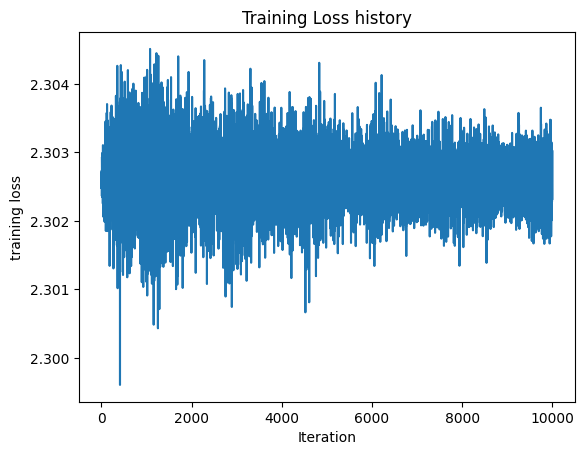

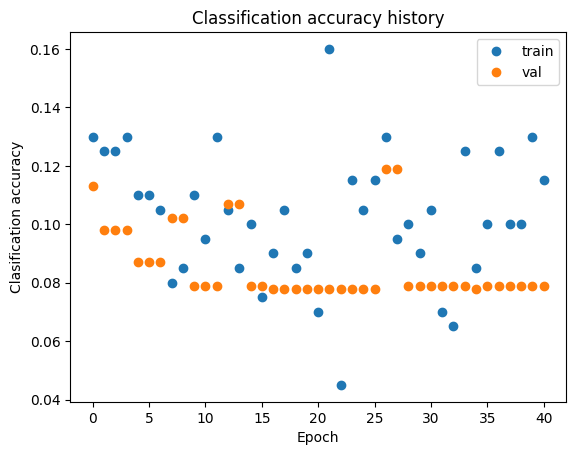

In [12]:
model = TwoLayerNet(input_size=X_train.shape[1], hidden_size=128, output_size=10, device='cpu')
tic = time.time()
stats = model.train(X_train, y_train, X_val, y_val, verbose=False, num_iters=10000)
toc = time.time()

print('That took %fs' % (toc - tic))
visualization(stats)


### Hyperparameters tuning (10 pts)

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, and regularization strength. You might also consider tuning other parameters such as num_iters as well.

**Approximate results**. To get full credit for the assignment, you should achieve a classification accuracy above 50% on the validation set.

In [ ]:
results = {}
best_val = -1
best_nn = None
################################################################################
# TODO (10 pts):                                                               #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
# fill in your own values
learning_rates = [1e-3, 1e-4, 1e-5]
regularization_strengths = [1e-6, 1e-7, 1e-8]
hidden_dims = [64, 128, 256]

for lr in learning_rates:
    for reg in regularization_strengths:
        for hidden_dim in hidden_dims:
            model = TwoLayerNet(input_size=X_train.shape[1], hidden_size=hidden_dim, output_size=10, device='cpu')
            stats = model.train(X_train, y_train, X_val, y_val, learning_rate = lr, reg=reg, verbose=False, num_iters=10000)

            final_val_acc = stats['val_acc_history'][-1]
            final_train_acc = stats['train_acc_history'][-1]
            if final_val_acc > best_val:
                best_val = final_val_acc
                best_nn = model
                results[(lr, reg, hidden_dim)] = (final_train_acc, final_val_acc)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg, H in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, H)]
    print('lr %e reg %e H %e train accuracy: %f val accuracy: %f' % (
                lr, reg, H, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

y_test_pred = best_nn.predict(X_test)
test_acc = (y_test_pred == y_test).double().mean().item()
print('final test accuracy 2-layered neural network achieved: %f' % test_acc)


# Acknowledgement

Credits to [UMichigan's 498/598 Deep Learning for Computer Vision](https://web.eecs.umich.edu/~justincj/teaching/eecs498/FA2020/) and Stanfords's [CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/), some code is adapted from their courses's assignments.